## Imports

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import warnings
import os
import s3fs
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier



warnings.filterwarnings("ignore")



# We fix a random state for the entire code to ensure reproducibility
RANDOM_STATE = 42

In [2]:
def load_data(file_key, train=False, test=False):
    if train:
        df = pd.read_csv("/Users/aroldtoubert/Downloads/Train_Data/"+file_key)
    if test:
        df = pd.read_csv("/Users/aroldtoubert/Downloads/Test_Data/"+file_key)
    return df

train_home_team = load_data("train_home_team_statistics_df.csv", train=True)
train_away_team = load_data("train_away_team_statistics_df.csv", train=True)
train_home_player = load_data("train_home_player_statistics_df.csv", train=True)
train_away_player = load_data("train_away_player_statistics_df.csv", train=True)
train_scores = pd.read_csv("/Users/aroldtoubert/Downloads/Y_train.csv")

test_home_team = load_data("test_home_team_statistics_df.csv", test=True)
test_away_team = load_data("test_away_team_statistics_df.csv", test=True)
test_home_player = load_data("test_home_player_statistics_df.csv", test=True)
test_away_player = load_data("test_away_player_statistics_df.csv", test=True)

## Data preprocessing

In [3]:
# Function to add prefixes to columns (HOME_ and AWAY_)
def prefix_columns(df, prefix):
    df = df.rename(columns={col: f"{prefix}_{col}" if col != 'ID' else col for col in df.columns})
    return df


train_home_team_prefixed = prefix_columns(train_home_team, 'HOME')
train_away_team_prefixed = prefix_columns(train_away_team, 'AWAY')

# We merge the home and away team dataframes on 'ID'
train_team = pd.merge(train_home_team_prefixed, train_away_team_prefixed, on='ID', how='inner')


In [4]:
train_home_player.isnull().all(axis=1).sum()

np.int64(0)

In [5]:
def aggregate_player_stats(df, prefix, is_train=False, position_mode=None, scaler=None):
    """
    Aggregates player stats by position for each team with mode imputation
    
    Args:
        df: DataFrame with player statistics (without prefixes)
        prefix: 'HOME' or 'AWAY' prefix to add to column names
        is_train: Boolean indicating if this is training data
        position_mode: Mode value for position imputation (passed from training data)
        scaler: Fitted StandardScaler (passed from training data)
    
    Returns:
        DataFrame with aggregated stats and fitted objects if is_train=True
    """
    # Deep copy to avoid modifications to original data
    df = df.copy()
    
    # Define position column name
    position_col = 'POSITION'
    
    # Handle missing positions (there are a lot so we need to fill them to aggregate the data by position)
    if is_train:
        # Calculate mode for positions (KNN was overfitting)
        position_mode = df[position_col].mode()[0]
        # Fill missing positions with mode (here, midfielders are the most common)
        df[position_col] = df[position_col].fillna(position_mode)
        
        # Fit scaler on training data
        scaler = StandardScaler()
        features_for_scaling = [col for col in df.columns 
                              if col.endswith('_season_sum') 
                              and col != position_col]
        scaler.fit(df[features_for_scaling])
    else: # For test data to ensure consistency in the preprocessing
        if position_mode is None or scaler is None:
            raise ValueError("position_mode and scaler must be provided for test data")
            
        # Fill missing positions with training mode 
        df[position_col] = df[position_col].fillna(position_mode)


    season_total_columns = [col for col in df.columns if col.endswith('_season_sum')]
    
    # Aggregate statistics by ID and position
    agg_stats = df.groupby(['ID', position_col])[season_total_columns].agg([
        'mean', 'min', 'max', 'std'
    ]).reset_index()
    
    pivoted_stats = pd.pivot_table(
        agg_stats,
        index='ID',
        columns=position_col,
        values=[col for col in agg_stats.columns if col not in ['ID', position_col]]
    ).reset_index()
    
    pivoted_stats.columns = [
        f"{prefix}_{col[0]}_{col[1]}_{col[2]}" if col[1] != "" 
        else f"{prefix}_{col[0]}" if col[0] != "ID" else "ID"
        for col in pivoted_stats.columns
    ]
    
    # Fill NaN values with 0 after aggregation to avoid overfitting
    pivoted_stats = pivoted_stats.fillna(0)
    
    if is_train:
        return pivoted_stats, position_mode, scaler
    return pivoted_stats

    
train_home_player_agg, home_position_mode, home_scaler = aggregate_player_stats(
    train_home_player, 'HOME', is_train=True
)
train_away_player_agg, away_position_mode, away_scaler = aggregate_player_stats(
    train_away_player, 'AWAY', is_train=True
)

In [6]:

train_data = (
    train_team
    .merge(train_home_player_agg, on='ID', how='left')
    .merge(train_away_player_agg, on='ID', how='left')
)

In [7]:
# Create target
train_scores['target'] = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']].idxmax(axis=1)
target_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
train_scores['target'] = train_scores['target'].map(target_mapping)
y = train_scores['target']

# Removing unnecessary columns (columns taht are not available in test data)
train_data = train_data.drop(['HOME_LEAGUE', 'HOME_TEAM_NAME', 'AWAY_LEAGUE', 'AWAY_TEAM_NAME'], axis=1)


In [8]:
ids = train_data['ID'].copy()
train_data = train_data.drop('ID', axis=1)
train_data = train_data.dropna(axis=1, how='all')


In [9]:
# Feature engineering 
def add_features(df):
    """Simplified feature engineering focusing on most predictive features"""
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df)
    else:
        df = df.copy() 

        # Helper function for safe calculations for divisions
    def safe_div(a, b):
        return np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    
    df['GOALS_DIFFERENCE'] = df['HOME_TEAM_GOALS_season_sum'] - df['AWAY_TEAM_GOALS_season_sum']
    df['FORM_DIFFERENCE'] = df['HOME_TEAM_GAME_WON_5_last_match_sum'] - df['AWAY_TEAM_GAME_WON_5_last_match_sum']
    df['POSSESSION_DOMINANCE'] = df['HOME_TEAM_BALL_POSSESSION_season_average'] - df['AWAY_TEAM_BALL_POSSESSION_season_average']

    # Attacking efficiency metrics
    # Shots conversion rate (season)
    df['HOME_SHOT_CONVERSION_RATE'] = safe_div(
        df['HOME_TEAM_GOALS_season_sum'],
        df['HOME_TEAM_SHOTS_ON_TARGET_season_sum']
    )
    df['AWAY_SHOT_CONVERSION_RATE'] = safe_div(
        df['AWAY_TEAM_GOALS_season_sum'],
        df['AWAY_TEAM_SHOTS_ON_TARGET_season_sum']
    )
    
    # Shot accuracy
    df['HOME_SHOT_ACCURACY'] = safe_div(
        df['HOME_TEAM_SHOTS_ON_TARGET_season_sum'],
        df['HOME_TEAM_SHOTS_TOTAL_season_sum']
    )
    df['AWAY_SHOT_ACCURACY'] = safe_div(
        df['AWAY_TEAM_SHOTS_ON_TARGET_season_sum'],
        df['AWAY_TEAM_SHOTS_TOTAL_season_sum']
    )

    # Defensive metrics
    # Save rate
    df['HOME_SAVE_RATE'] = safe_div(
        df['HOME_TEAM_SAVES_season_sum'],
        df['HOME_TEAM_SHOTS_ON_TARGET_season_sum']
    )
    df['AWAY_SAVE_RATE'] = safe_div(
        df['AWAY_TEAM_SAVES_season_sum'],
        df['AWAY_TEAM_SHOTS_ON_TARGET_season_sum']
    )

    # Form metrics
    # Recent form (last 5 matches)
    df['HOME_RECENT_FORM'] = (
        3 * df['HOME_TEAM_GAME_WON_5_last_match_sum'] + 
        df['HOME_TEAM_GAME_DRAW_5_last_match_sum']
    ) / 15  # Max possible points (5 matches * 3 points)
    
    df['AWAY_RECENT_FORM'] = (
        3 * df['AWAY_TEAM_GAME_WON_5_last_match_sum'] + 
        df['AWAY_TEAM_GAME_DRAW_5_last_match_sum']
    ) / 15

    # Momentum indicators
    # Goals trend (comparing last 5 matches to season average)
    df['HOME_GOAL_MOMENTUM'] = safe_div(
        df['HOME_TEAM_GOALS_5_last_match_average'],
        df['HOME_TEAM_GOALS_season_average']
    )
    df['AWAY_GOAL_MOMENTUM'] = safe_div(
        df['AWAY_TEAM_GOALS_5_last_match_average'],
        df['AWAY_TEAM_GOALS_season_average']
    )

    # Comparative metrics
    # Head-to-head performance indicators
    df['FORM_DIFFERENCE_UPGRADED'] = df['HOME_RECENT_FORM'] - df['AWAY_RECENT_FORM']
    df['GOAL_MOMENTUM_DIFFERENCE'] = df['HOME_GOAL_MOMENTUM'] - df['AWAY_GOAL_MOMENTUM']
    df['SHOT_ACCURACY_DIFFERENCE'] = df['HOME_SHOT_ACCURACY'] - df['AWAY_SHOT_ACCURACY']

    

    
    # Offensive/Defensive balance
    # Attack vs Defense rating

    df['HOME_ATTACK_DEFENSE_RATING'] = safe_div(
        df['HOME_TEAM_GOALS_season_average'],
        df['HOME_TEAM_GOALS_season_average'] + df['AWAY_TEAM_GOALS_season_average']
    )
    df['AWAY_ATTACK_DEFENSE_RATING'] = 1 - df['HOME_ATTACK_DEFENSE_RATING']

    # Consistency metrics
    # Performance stability (using std of various metrics)
    df['HOME_PERFORMANCE_STABILITY'] = (
        df['HOME_TEAM_GOALS_season_std'] + 
        df['HOME_TEAM_SHOTS_ON_TARGET_season_std']
    ) / 2
    df['AWAY_PERFORMANCE_STABILITY'] = (
        df['AWAY_TEAM_GOALS_season_std'] + 
        df['AWAY_TEAM_SHOTS_ON_TARGET_season_std']
    ) / 2

    # possession effectiveness
    df['HOME_POSSESSION_EFFECTIVENESS'] = safe_div(
        df['HOME_TEAM_GOALS_season_average'],
        df['HOME_TEAM_BALL_POSSESSION_season_average']
    )
    df['AWAY_POSSESSION_EFFECTIVENESS'] = safe_div(
        df['AWAY_TEAM_GOALS_season_average'],
        df['AWAY_TEAM_BALL_POSSESSION_season_average']
    )

    return df


Class Distribution:
target
0    0.435341
2    0.305698
1    0.258961
Name: proportion, dtype: float64


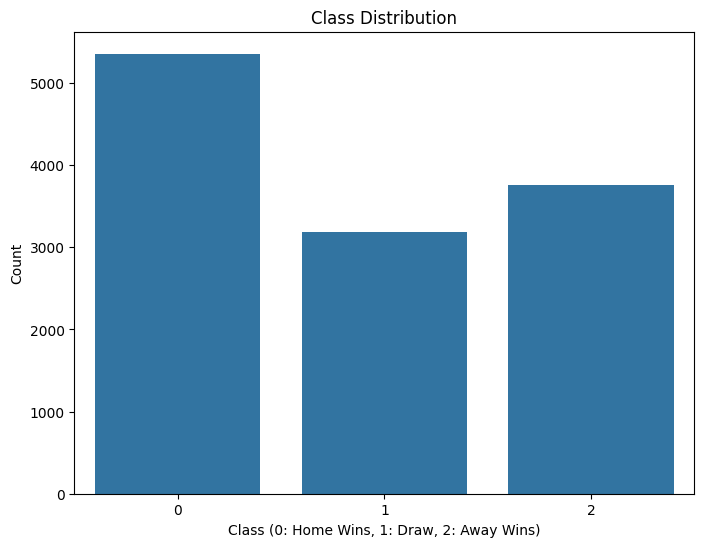

In [10]:
# Class distribition : there is a class imbalance
print("\nClass Distribution:")
class_dist = pd.Series(y).value_counts(normalize=True)
print(class_dist)

plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Class (0: Home Wins, 1: Draw, 2: Away Wins)')
plt.ylabel('Count')
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE # careful to use stratify=y to ensure class balance in the split
)

In [12]:
X_train.head()

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,AWAY_PLAYER_YELLOWCARDS_season_sum_mean_goalkeeper,AWAY_PLAYER_YELLOWCARDS_season_sum_mean_midfielder,AWAY_PLAYER_YELLOWCARDS_season_sum_min_attacker,AWAY_PLAYER_YELLOWCARDS_season_sum_min_defender,AWAY_PLAYER_YELLOWCARDS_season_sum_min_goalkeeper,AWAY_PLAYER_YELLOWCARDS_season_sum_min_midfielder,AWAY_PLAYER_YELLOWCARDS_season_sum_std_attacker,AWAY_PLAYER_YELLOWCARDS_season_sum_std_defender,AWAY_PLAYER_YELLOWCARDS_season_sum_std_goalkeeper,AWAY_PLAYER_YELLOWCARDS_season_sum_std_midfielder
7157,5.0,4.0,7.0,4.0,4.0,4.0,3.0,1.0,6.0,6.0,...,0.000000,35.750000,0.0,0.0,0.0,0.0,6.928203,20.947554,0.000000,28.803522
773,7.0,5.0,8.0,3.0,4.0,4.0,3.0,6.0,6.0,4.0,...,6.000000,14.545455,0.0,12.0,0.0,0.0,0.000000,16.268579,8.485281,16.561181
6085,6.0,5.0,5.0,7.0,5.0,10.0,10.0,10.0,10.0,3.0,...,16.666667,18.076923,0.0,12.0,0.0,0.0,0.000000,15.345233,28.867513,18.135883
6011,10.0,9.0,7.0,7.0,7.0,10.0,10.0,4.0,9.0,4.0,...,10.000000,28.571429,0.0,0.0,0.0,0.0,10.000000,24.944383,14.142136,22.677868
7065,6.0,4.0,6.0,6.0,8.0,9.0,10.0,6.0,6.0,4.0,...,0.000000,20.000000,10.0,0.0,0.0,0.0,16.733201,28.660575,0.000000,16.329932


In [13]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_ = None
        
    def fit(self, X, y=None):
        # Convert to DataFrame if needed
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
        
        self.feature_names_ = X.columns.tolist()
        return self
        
    def transform(self, X):
        # Convert to DataFrame if needed
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names_)
            
        result = add_features(X)
        
        # Ensure output is DataFrame
        if isinstance(result, np.ndarray):
            result = pd.DataFrame(result, columns=self.feature_names_)
            
        return result
    
    def get_feature_names_out(self):
        return self.feature_names_

In [14]:
class EnhancedFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=40):
        self.n_features = n_features
        self.selected_features = None
        self.feature_importance_ = None
        
    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            # Convert to DataFrame using default column names
            X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
        
        self.feature_names_ = X.columns.tolist()
        print(f"Starting feature selection with {X.shape[1]} features...")
        
        # Remove low variance features to keep only informative ones
        selector = VarianceThreshold(threshold=0.01)
        X_var = selector.fit_transform(X)
        var_features = X.columns[selector.get_support()].tolist()
        print(f"After variance threshold: {len(var_features)} features")
        
        # Remove highly correlated features to avoid redundancy
        corr_matrix = X[var_features].corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
        uncorr_features = [f for f in var_features if f not in to_drop]
        print(f"After correlation filter: {len(uncorr_features)} features")
        
        # Calculate feature importance using multiple estimators
        X_filtered = X[uncorr_features]
        
        # Random Forest importance
        rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
        rf.fit(X_filtered, y)
        rf_importance = pd.Series(rf.feature_importances_, index=uncorr_features)
        
        # XGBoost importance
        xgb_model = xgb.XGBClassifier(random_state=RANDOM_STATE)
        xgb_model.fit(X_filtered, y)
        xgb_importance = pd.Series(xgb_model.feature_importances_, index=uncorr_features)
        
        # LightGBM importance
        lgb_model = lgb.LGBMClassifier(random_state=RANDOM_STATE)
        lgb_model.fit(X_filtered, y)
        lgb_importance = pd.Series(lgb_model.feature_importances_, index=uncorr_features)

        # Mutual Information
        mi_scores = pd.Series(
            mutual_info_classif(X_filtered, y, random_state=RANDOM_STATE),
            index=uncorr_features
        )
        
        # Combine importances to create a combined score
        feature_scores = pd.DataFrame({
            'rf_importance': rf_importance,
            'mi_score': mi_scores,
            'xgb_importance': xgb_importance,
            'lgb_importance': lgb_importance
        })
        
        # Normalize each score
        for col in feature_scores.columns:
            feature_scores[col] = feature_scores[col] / feature_scores[col].max()
        
        # Calculate combined score with equal weights
        feature_scores['combined_score'] = (
            feature_scores['rf_importance'] * 0.25 +
            feature_scores['mi_score'] * 0.25 +
            feature_scores['xgb_importance'] * 0.25 +
            feature_scores['lgb_importance'] * 0.25
        )
        
        self.selected_features = feature_scores.nlargest(self.n_features, 'combined_score').index.tolist()
        self.feature_importance_ = feature_scores['combined_score']
        
        print(f"Final selected features: {len(self.selected_features)}")
        print("\nTop 10 selected features:")
        print(feature_scores['combined_score'].nlargest(10))
        
        return self
        
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            # Convert to DataFrame using saved feature names from fit
            X = pd.DataFrame(X, columns=self.feature_names_)
        return X[self.selected_features]
        
    def get_feature_names_out(self):
        return np.array(self.selected_features)

In [15]:
# To preserve DataFrame structure when imputing
class DataFramePreservingImputer(SimpleImputer):
    """Custom imputer that preserves DataFrame structure"""
    def fit_transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
            arr = super().fit_transform(X)
            return pd.DataFrame(arr, columns=self.columns_)
        return super().fit_transform(X)
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            arr = super().transform(X)
            return pd.DataFrame(arr, columns=self.columns_)
        return super().transform(X)

In [16]:
# Same for scaling
class DataFramePreservingScaler(RobustScaler):
    """Custom scaler that preserves DataFrame structure"""
    def fit_transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
            arr = super().fit_transform(X)
            return pd.DataFrame(arr, columns=self.columns_)
        return super().fit_transform(X)
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            arr = super().transform(X)
            return pd.DataFrame(arr, columns=self.columns_)
        return super().transform(X)

In [17]:
# And same for SMOTEENN
class DataFramePreservingSMOTEENN(SMOTEENN):
    """Custom SMOTEENN that preserves DataFrame structure"""
    def __init__(self, sampling_strategy=None, random_state=None, n_jobs=None):
        super().__init__(sampling_strategy=sampling_strategy, random_state=random_state, n_jobs=n_jobs)
        self.columns_ = None
        
    def fit_resample(self, X, y):
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
            X_res, y_res = super().fit_resample(X, y)
            return pd.DataFrame(X_res, columns=self.columns_), y_res
        return super().fit_resample(X, y)

In [18]:
# To select only features selected by EnhancedFeatureSelector
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.column_indices_ = None
        self.feature_names_ = None
        
    def fit(self, X, y=None):
        # Convert numpy array to DataFrame if needed
        if isinstance(X, np.ndarray):
            self.feature_names_ = [f'feature_{i}' for i in range(X.shape[1])]
            X = pd.DataFrame(X, columns=self.feature_names_)
        else:
            self.feature_names_ = X.columns.tolist()
            
        # Get indices of columns to select
        self.column_indices_ = [self.feature_names_.index(col) for col in self.columns]
        return self
        
    def transform(self, X):
        # Handle numpy array
        if isinstance(X, np.ndarray):
            return X[:, self.column_indices_]
            
        # Handle DataFrame
        if isinstance(X, pd.DataFrame):
            return X[self.columns]
            
        raise TypeError("Input must be either numpy array or pandas DataFrame")
        
    def get_feature_names_out(self, input_features=None):
        return np.array(self.columns)

## Feature selection

In [19]:
# Apply the transformations

imputer = DataFramePreservingImputer(strategy='median')
X_imputed = imputer.fit_transform(train_data)

feature_eng = FeatureEngineeringTransformer()
X_featured = feature_eng.fit_transform(X_imputed)

scaler = DataFramePreservingScaler()
X_scaled = scaler.fit_transform(X_featured)

feature_selector = EnhancedFeatureSelector(n_features=50)
X_selected = feature_selector.fit_transform(X_scaled, y)
selected_features = feature_selector.get_feature_names_out()

Starting feature selection with 1774 features...
After variance threshold: 1638 features
After correlation filter: 657 features
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25841
[LightGBM] [Info] Number of data points in the train set: 12303, number of used features: 618
[LightGBM] [Info] Start training from score -0.831626
[LightGBM] [Info] Start training from score -1.351077
[LightGBM] [Info] Start training from score -1.185158
Final selected features: 50

Top 10 selected features:
POSSESSION_DOMINANCE                                     0.934244
GOALS_DIFFERENCE                                         0.890681
AWAY_PLAYER_GOALS_CONCEDED_season_sum_std_midfielder     0.552098
HOME_PLAYER_GOALS_CONCEDED_season_sum_std_midfielder     0.515419
HOME_PLAYER_ASSISTS_season_sum_mean_

## Models

In [20]:
# Create model pipeline with resampling to ensure consistency with train data
def create_model_pipeline(model, with_resampling=True):
    steps = [
        ('imputer', DataFramePreservingImputer(strategy='median')),
        ('feature_engineering', FeatureEngineeringTransformer()),
        ('scaler', DataFramePreservingScaler()),
    ]
    
    # Add feature names to ColumnSelector
    if selected_features is not None:
        steps.append(('feature_selection', ColumnSelector(columns=selected_features)))
    
    if with_resampling:
        total_samples = y.shape[0]
        target_per_class = int(total_samples / 3)
        
        steps.append(('resampling', DataFramePreservingSMOTEENN(
            sampling_strategy={
                1: target_per_class,
                2: target_per_class
            },
            random_state=RANDOM_STATE,
            n_jobs=-1
        )))
    
    steps.append(('model', model))
    
    # Create pipeline
    pipeline = ImbPipeline(steps) if with_resampling else Pipeline(steps)
    
    return pipeline

In [21]:
def evaluate_model(model, X, y, model_name):
    """Enhanced model evaluation with multiple metrics"""
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    # Calculate multiple metrics
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'weighted_f1': f1_score(y, y_pred, average='weighted'),
        'macro_f1': f1_score(y, y_pred, average='macro'),
        'roc_auc': roc_auc_score(y, y_pred_proba, multi_class='ovr')
    }
    
    print(f"\n{model_name} Results:")
    for metric_name, score in metrics.items():
        print(f"{metric_name}: {score:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    # Confusion matrix visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y, y_pred), 
                annot=True, 
                fmt='d',
                cmap='Blues',
                xticklabels=['Home', 'Draw', 'Away'],
                yticklabels=['Home', 'Draw', 'Away'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'metrics': metrics,
        'model': model
    }

In [22]:
def create_ensemble_model():
    estimators = []
    
    # Add models for the stacking
    estimators.append(('gb', GradientBoostingClassifier(
        n_estimators=100, 
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_STATE
    )))
    
    estimators.append(('hist_gb', HistGradientBoostingClassifier(
        max_iter=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_STATE
    )))
    

    
    estimators.append(('mlp', MLPClassifier(
        hidden_layer_sizes=(100,),
        alpha=0.0001,
        max_iter=500,
        early_stopping=True,
        random_state=RANDOM_STATE
    )))
    
    estimators.append(('et', ExtraTreesClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        random_state=RANDOM_STATE
    )))
    
    estimators.append(('lr', LogisticRegression(multi_class='ovr', random_state=RANDOM_STATE)))
    estimators.append(('svm', SVC(probability=True, random_state=RANDOM_STATE)))
    
    # Meta-classifier is a Logistic Regression (simple and not overfitting)
    final_estimator = LogisticRegression(
        multi_class='ovr',
        random_state=RANDOM_STATE,
        max_iter=1000
    )
    
    # Create stacking classifier with cross-validation
    return StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=RANDOM_STATE),
        stack_method='predict_proba',
        n_jobs=1
    )


Ensemble Results:
accuracy: 0.4945
weighted_f1: 0.4151
macro_f1: 0.3643
roc_auc: 0.6266

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.81      0.63      1072
           1       0.50      0.00      0.01       637
           2       0.46      0.46      0.46       752

    accuracy                           0.49      2461
   macro avg       0.49      0.42      0.36      2461
weighted avg       0.49      0.49      0.42      2461



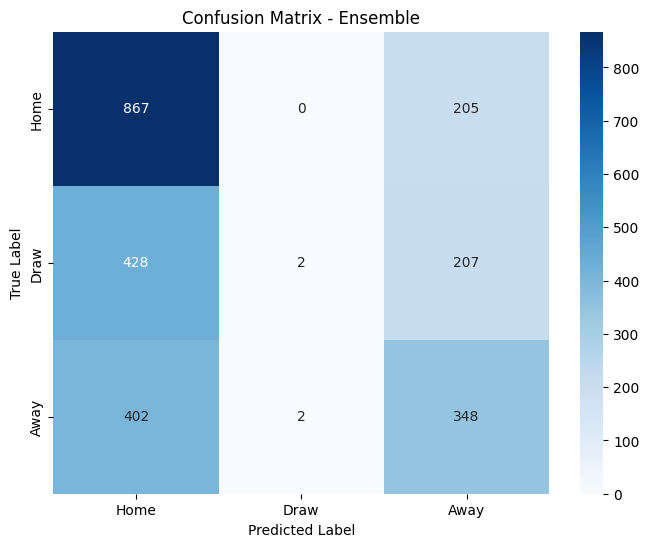

In [23]:
# Create and evaluate ensemble model
ensemble = create_ensemble_model()


ensemble_pipeline = Pipeline([
    ('imputer', DataFramePreservingImputer(strategy='median')),
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('scaler', DataFramePreservingScaler()),
    ('feature_selection', ColumnSelector(columns=selected_features)),
    ('model', ensemble)
])

# Train and evaluate the ensemble model
ensemble_pipeline.fit(X_train, y_train)


ensemble_metrics = evaluate_model(ensemble_pipeline, X_test, y_test, "Ensemble")


In [24]:
best_model_name = 'ensemble'
best_model = ensemble_metrics['model']



In [25]:
# Retraining the best model on all data to take advantage of all available data
print(f"Retraining {best_model_name} on all data...")


final_pipeline = Pipeline([
    ('imputer', DataFramePreservingImputer(strategy='median')),
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('scaler', DataFramePreservingScaler()),
    ('feature_selection', ColumnSelector(columns=selected_features)),
    ('model', ensemble)
])


final_pipeline.fit(train_data, y)

Retraining ensemble on all data...


Pipeline(steps=[('imputer', DataFramePreservingImputer(strategy='median')),
                ('feature_engineering', FeatureEngineeringTransformer()),
                ('scaler', DataFramePreservingScaler()),
                ('feature_selection',
                 ColumnSelector(columns=array(['POSSESSION_DOMINANCE', 'GOALS_DIFFERENCE',
       'AWAY_PLAYER_GOALS_CONCEDED_season_sum_std_midfielder',
       'HOME_PLAYER_GOALS_CONCEDED_seaso...
                                                 MLPClassifier(early_stopping=True,
                                                               max_iter=500,
                                                               random_state=42)),
                                                ('et',
                                                 ExtraTreesClassifier(max_depth=10,
                                                                      random_state=42)),
                                                ('lr',
                                                 LogisticRegression(multi_class='ovr',
                                                                    random_state=42)),
                                                ('svm',
                                                 SVC(probability=True,
                                                     random_state=42))],
                                    final_estimator=LogisticRegression(max_iter=1000,
                                                                       multi_class='ovr',
                                                                       random_state=42),
                                    n_jobs=1, stack_method='predict_proba'))])

## Test data preprocessing and predictions

In [26]:
# Prepare test data for prediction with consistency in preprocessing
def prepare_test_data():
   
    test_home_team_prefixed = prefix_columns(test_home_team, 'HOME')
    test_away_team_prefixed = prefix_columns(test_away_team, 'AWAY')
    
   
    test_team = pd.merge(test_home_team_prefixed, test_away_team_prefixed, on='ID', how='inner')
    
   
    test_home_player_agg = aggregate_player_stats(
    test_home_player, 'HOME', is_train=False, 
    position_mode=home_position_mode, 
    scaler=home_scaler
    )
    test_away_player_agg = aggregate_player_stats(
        test_away_player, 'AWAY', is_train=False, 
        position_mode=away_position_mode,
        scaler=away_scaler
    )
    
   
    test_data = test_team.merge(test_home_player_agg, on='ID', how='inner').merge(test_away_player_agg, on='ID', how='inner')
    
    
    test_data = test_data.drop(['HOME_LEAGUE', 'HOME_TEAM_NAME', 'AWAY_LEAGUE', 'AWAY_TEAM_NAME'], axis=1, errors='ignore')
    

    test_ids = test_data['ID'].copy()
    test_data = test_data.drop('ID', axis=1)
    
    # Very important: Ensure test_data has the same columns as train_data in the same order
    train_columns = train_data.columns.tolist()
    
    # Add missing columns with NaN values
    for col in train_columns:
        if col not in test_data.columns:
            test_data[col] = np.nan
    
    # Keep only columns that were in the training data and in the same order
    test_data = test_data[train_columns]
    
    # Verify column alignment
    assert list(test_data.columns) == list(train_data.columns), "Column mismatch after alignment"
    
    return test_data, test_ids

# Prepare test data
test_data, test_ids = prepare_test_data()

# Do predictions on test data
test_predictions = final_pipeline.predict(test_data)
test_probabilities = final_pipeline.predict_proba(test_data)


In [27]:
# Create submission file
submission = pd.DataFrame({
    'ID': test_ids,
    'HOME_WINS': (test_predictions == 0).astype(int),
    'DRAW': (test_predictions == 1).astype(int),
    'AWAY_WINS': (test_predictions == 2).astype(int)
})

submission_file = 'submission_qrt.csv'
submission.to_csv(submission_file, index=False)
print(f"Submission file saved as {submission_file}")

Submission file saved as submission_qrt.csv
